## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.compose import ColumnTransformer

In [2]:
# read in eda data
pet_df = pd.read_csv('../data/eda_pets.csv').drop(columns = ['Unnamed: 0', 'created_utc'])

# check
pet_df.head()

,subreddit,selftext,title,text_length,title_length,text_word_count,title_word_count
0,dogs,So my miniature poodle can't last more than 10...,Barking when he is alone and awake,705,34,130,7
1,dogs,Genuinely curious. My vet won’t answer this qu...,When is an appropriate age to start taking you...,914,79,178,15
2,dogs,My 2.5 year mixed breed male dog has to have k...,Knee surgery,546,12,95,2
3,dogs,I’m new to reddit and came across this sub. I ...,Positive and Negative Punishment,3611,32,648,4
4,dogs,Looking for advice on which dog washing statio...,HOA Agreed to purchase dog washing station,283,42,54,7


In [3]:
# make column that combines 'selftext' and 'title'
pet_df['text_and_title'] = pet_df['selftext'] + pet_df['title']

In [4]:
pet_df.head()

,subreddit,selftext,title,text_length,title_length,text_word_count,title_word_count,text_and_title
0,dogs,So my miniature poodle can't last more than 10...,Barking when he is alone and awake,705,34,130,7,So my miniature poodle can't last more than 10...
1,dogs,Genuinely curious. My vet won’t answer this qu...,When is an appropriate age to start taking you...,914,79,178,15,Genuinely curious. My vet won’t answer this qu...
2,dogs,My 2.5 year mixed breed male dog has to have k...,Knee surgery,546,12,95,2,My 2.5 year mixed breed male dog has to have k...
3,dogs,I’m new to reddit and came across this sub. I ...,Positive and Negative Punishment,3611,32,648,4,I’m new to reddit and came across this sub. I ...
4,dogs,Looking for advice on which dog washing statio...,HOA Agreed to purchase dog washing station,283,42,54,7,Looking for advice on which dog washing statio...


## Modeling

#### Train/Test Split

In [5]:
pet_df.shape

(2000, 8)

In [6]:
# set up X and y
X = pet_df['text_and_title']
y = pet_df['subreddit']

In [7]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

In [8]:
# check baseline accuracy
y_test.value_counts(normalize = True)

dogs    0.5
cats    0.5
Name: subreddit, dtype: float64

In [9]:
# value counts for y_train and y_test
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

cats    0.5
dogs    0.5
Name: subreddit, dtype: float64
dogs    0.5
cats    0.5
Name: subreddit, dtype: float64


## Pre-Processing

#### Stop Words

In [10]:
stop_words = stopwords.words('english')

new_stopwords = ['webp', 'https', 'preview', 'amp', 'format', 'enabled', 'auto', 'dog', 'dogs', 'cat', 'cats', 'puppy', 'puppies', 'kitty', 'kitties']

In [11]:
# combine both lists
all_stopwords = stop_words + new_stopwords

In [12]:
# check
print(all_stopwords)

print(len(all_stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
X_train

1538                                     tatlı şirin kedı
1879     i found a kitten and i would love to keep it ...
58      My golden retriever, for whatever reason, seem...
9       So my Australian cattle dog boxer collie mix i...
1268     This gang of feral cats I met in Hawaii looke...
                              ...                        
836     We will be taking our good boy corgi home from...
1452                                 show me cat in a bag
387     What dog breed is right for me?\n\n\- I live i...
266     I went away over Christmas and as he was with ...
537     Hoping I might be able to crowdsource some ins...
Name: text_and_title, Length: 1500, dtype: object

In [17]:
X_train.shape

(1500,)

In [18]:
type(X_train)

pandas.core.series.Series

#### Logistic Regression

In [86]:
lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [87]:
lr_pipe_params = {
    'cvec__stop_words': ['english', all_stopwords],
    'cvec__max_features': [1000,3000,5000],
    'cvec__min_df': [1,3,5],
    'cvec__max_df': [0.8, 0.9],
    'cvec__ngram_range': [(1,1),(1, 2)]
}

In [88]:
# gridsearch
lr_gs = GridSearchCV(lr_pipe, param_grid = lr_pipe_params, n_jobs = -1)

In [89]:
# fit
lr_gs.fit(X_train, y_train)

/Users/cammiismugereski/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.9],
                         'cvec__max_features': [1000, 3000, 5000],
                         'cvec__min_df': [1, 3, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
           

In [90]:
# best params
lr_gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 1000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [91]:
# print scores
print(f'Training Score: {lr_gs.score(X_train, y_train)}')
print(f'Testing Score: {lr_gs.score(X_test, y_test)}')

Training Score: 0.992
Testing Score: 0.958


#### Naïve Bayes

In [19]:
nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [20]:
nb_pipe_params = {
    'cvec__stop_words': [stopwords.words('english'), all_stopwords],
    'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.7, 0.8, 0.9],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [21]:
# gridsearch
nb_gs = GridSearchCV(nb_pipe, param_grid = nb_pipe_params, n_jobs = -1)

In [22]:
# fit
nb_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.7, 0.8, 0.9],
                         'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll...
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it

In [23]:
# best score
nb_gs.best_score_

0.9039999999999999

In [24]:
# best params
nb_gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 1000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',

In [30]:
# print scores
print(f'Training Score: {nb_gs.score(X_train, y_train)}')
print(f'Testing Score: {nb_gs.score(X_test, y_test)}')

Training Score: 0.934
Testing Score: 0.916


#### Random Forest

In [25]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [26]:
rf_pipe_params = {
    'rf__n_estimators':[50,100,150],
    'rf__max_depth':[None,5],
    'rf__min_samples_split':[2,5,10],
    'rf__ccp_alpha':[0,.01,.1],
    'cvec__stop_words': ['english', all_stopwords],
    'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'cvec__min_df': range(1,3,5),
    'cvec__max_df': [0.8, 0.9],
    'cvec__ngram_range': [(1, 2)]
}

In [27]:
rf_gs = GridSearchCV(rf_pipe, param_grid = rf_pipe_params, n_jobs=-1)

In [28]:
rf_gs.fit(X_train, y_train)

/Users/cammiismugereski/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.9],
                         'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
                         'cvec__min_df': range(1, 3, 5),
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her'

In [36]:
# best params
rf_gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 1000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'rf__ccp_alpha': 0,
 'rf__max_depth': None,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 150}

In [31]:
# print scores
print(f'Training Score: {rf_gs.score(X_train, y_train)}')
print(f'Testing Score: {rf_gs.score(X_test, y_test)}')

Training Score: 0.9953333333333333
Testing Score: 0.95


* Let's Try it with Tfidf Vectorizer instead of Count Vectorizer

#### Tfidf Vectorizer

In [32]:
rf_pipe_2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [33]:
rf_pipe_params_2 = {
    'rf__n_estimators':[50,100,150],
    'rf__max_depth':[None,5],
    'rf__min_samples_split':[2,5,10],
    'rf__ccp_alpha':[0,.01,.1],
    'tvec__stop_words': ['english', all_stopwords],
    'tvec__max_features': [1000, 2000, 3000],
    'tvec__min_df': range(1,3,5),
    'tvec__max_df': [0.7, 0.8, 0.9],
    'tvec__ngram_range': [(1, 2)]
}

In [34]:
rf_gs_2 = GridSearchCV(rf_pipe_2, param_grid = rf_pipe_params_2, n_jobs=-1)

In [35]:
rf_gs_2.fit(X_train, y_train)

/Users/cammiismugereski/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__ccp_alpha': [0, 0.01, 0.1],
                         'rf__max_depth': [None, 5],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [50, 100, 150],
                         'tvec__max_df': [0.7, 0.8, 0.9],
                         'tvec__max_features': [1000, 2000, 3000],
                         'tvec__min_df': range(1, 3, 5),
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
 

In [37]:
# best params
rf_gs_2.best_params_

{'rf__ccp_alpha': 0,
 'rf__max_depth': None,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 100,
 'tvec__max_df': 0.9,
 'tvec__max_features': 1000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [38]:
# print scores
print(f'Training Score: {rf_gs_2.score(X_train, y_train)}')
print(f'Testing Score: {rf_gs_2.score(X_test, y_test)}')

Training Score: 0.9953333333333333
Testing Score: 0.938


#### kNN

In [41]:
knn_pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('ss', StandardScaler(with_mean = False)),
    ('knn', KNeighborsClassifier())
])

In [43]:
knn_pipe_params = {
    'knn__n_neighbors':[5,7,9],
    'tf__stop_words': ['english', all_stopwords],
    'tf__max_features': [500,1000,2000],
    'tf__min_df': range(1,3),
    'tf__max_df': [0.8, 0.9],
    'tf__ngram_range': [(1,1),(1, 2)]
}

In [44]:
knn_gs = GridSearchCV(knn_pipe, param_grid = knn_pipe_params, n_jobs = -1)

In [45]:
knn_gs.fit(X_train, y_train)

/Users/cammiismugereski/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [5, 7, 9],
                         'tf__max_df': [0.8, 0.9],
                         'tf__max_features': [500, 1000, 2000],
                         'tf__min_df': range(1, 3),
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': ['english',
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                   

In [46]:
knn_gs.best_params_

{'knn__n_neighbors': 5,
 'tf__max_df': 0.8,
 'tf__max_features': 500,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': 'english'}

In [47]:
# print scores
print(f'Training Score: {knn_gs.score(X_train, y_train)}')
print(f'Testing Score: {knn_gs.score(X_test, y_test)}')

Training Score: 0.5846666666666667
Testing Score: 0.55


* kNN with Tfidf Vectorizer is definitely not performing as well as the others.

#### Stacking

In [66]:
level1_estimators = [
    ('lr', lr_gs.best_estimator_),
    ('nb', nb_gs.best_estimator_),
    ('rf', rf_gs.best_estimator_)
]

stacked = StackingClassifier(estimators = level1_estimators,
                                 final_estimator = RandomForestClassifier())

In [67]:
stacked.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(max_df=0.8,
                                                                 max_features=1000,
                                                                 stop_words='english')),
                                                ('lr', LogisticRegression())])),
                               ('nb',
                                Pipeline(steps=[('cvec',
                                                 CountVectorizer(max_df=0.7,
                                                                 max_features=1000,
                                                                 min_df=3,
                                                                 stop_words=['i',
                                                                             'me',
                                                                             '

In [69]:
# print scores
print(f'Training Score: {stacked.score(X_train, y_train)}')
print(f'Testing Score: {stacked.score(X_test, y_test)}')

Training Score: 0.9926666666666667
Testing Score: 0.964


* Our stacked model is the best performing

### Post-Model Analysis

##### Our post-model analysis will happen on our stacked model

In [71]:
# get predictions
preds = stacked.predict(X_test)
# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/cammiismugereski/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


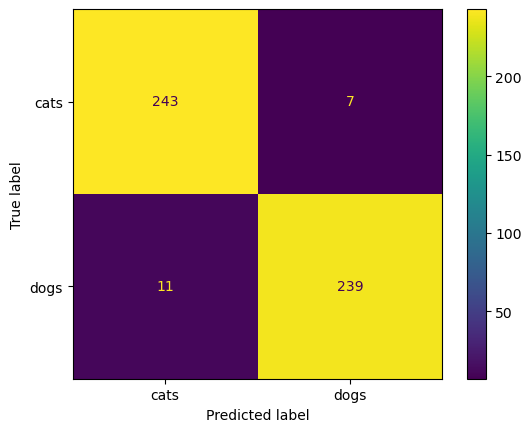

In [81]:
# visualize
plot_confusion_matrix(stacked, X_test, y_test);
plt.savefig('../images/stacked_confusion_matrix.png');

In [78]:
confusion_matrix(y_test, preds).ravel()

array([243,   7,  11, 239])

In [80]:
# calculate sensitivity
sens = tp / (tp + fn)

print(f'Sensitivity: {sens}')

Sensitivity: 0.956


* Sensitivity is our true positive rate and therefore tells us that 95% of our data that we predicted to be true, was actually really true in our stacked model.